# 📖 8-12. 프로젝트: 뉴스 기사 요약해보기
추상적 요약 / 추출적 요약을 모두 해보자.

In [99]:
import pandas as pd
import urllib.request
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# from tensorflow.python.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed from tensorflow.python.keras.models import Model

import requests
from summa.summarizer import summarize

## Step 1. 데이터 수집하기

In [100]:
import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

# data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data = pd.read_csv('news_summary_more_preprocessing.csv', encoding='iso-8859-1')


In [101]:
data.head(1)

,Unnamed: 0,headlines,text
0,0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...


In [102]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.sample(10)

,headlines,text
52045,luru men dancing in middle of road assault men...,video surfaced wherein group apparently drunk ...
64349,twitter mocks trump pumpkin caps for halloween,us president donald trump campaign team starte...
65954,couple finds hidden camera in bedroom of airbn...,airbnb host united states arrested couple alle...
50979,audi asked to recall lakh cars over faulty emi...,germany automotive watchdog asked volkswagen o...
22993,cybercriminals use fake income tax refund sms ...,cybercrime racket investigation using fake sms...
95371,sri lanka arrests indian fishermen for having ...,sri lankan navy apprehended six indian fisherm...
27475,govt approves hike in minimum support price fo...,centre wednesday approved raise minimum suppor...
70623,scientists demonstrate sinking objects with al...,first researchers demonstrated reduction water...
40311,corruption is on rise as compared to last govt...,listing reasons bjp loss kairana noorpur recen...
32127,snapchat parent cfo quits replaced by amazon exec,snapchat parent company snap chief financial o...


## Step 2. 데이터 전처리하기 (추상적 요약)
### 중복 샘플, null 값 제거
- text는 중복되어도 headlines는 동일할 수도 있다.
- 일단 text에서 중복된 데이터를 제거하자.

In [103]:
# print(len(data['text']))
# print(len(data['text']) - data['text'].nunique())

41개 98360개

In [104]:
# data.drop_duplicates(subset=['text'], inplace=True)
# print('전체 text 샘플 수: ', len(data))

In [105]:
# print(data.isnull().sum())

null data는 제거할 필요 없다. 총 데이터 수는 중복 데이터 41개를 제거해 **98,360개**임을 확인!

### 텍스트 정규화와 불용어 제거
#### 정규화 사전 (dictionary)

In [106]:
# contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
#                            "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
#                            "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
#                            "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
#                            "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
#                            "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
#                            "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
#                            "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
#                            "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
#                            "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
#                            "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
#                            "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
#                            "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
#                            "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
#                            "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
#                            "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
#                            "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
#                            "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
#                            "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
#                            "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
#                            "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
#                            "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
#                            "you're": "you are", "you've": "you have"}

# print("정규화 사전의 수: ", len(contractions))

#### 불용어 (stopwords)
- NLTK에서 제공하는 불용어 리스트를 참조하자.

In [107]:
# # NLTK에서 제공하는 불용어 리스트
# print('불용어 개수: ', len(stopwords.words('english')))
# print(stopwords.words('english'))

In [108]:
# # 데이터 전처리 함수
# def preprocess_sentence(sentence, remove_stopwords=True):
#     sentence = sentence.lower() # 텍스트 소문자화
#     sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href=...> 등의 html 태그 제거
#     sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
#     sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
#     sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
#     sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

#     # 불용어 제거 (text)
#     if remove_stopwords:
#         tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
#     # 불용어 미제거 (headlines)
#     else:
#         tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
#     return tokens

In [109]:
# clean_text = []

# # 전체 text 데이터에 대한 전처리: 10분 이상 소요
# for s in data['text']:
#     clean_text.append(preprocess_sentence(s))
    
# # 전처리 후 출력
# print('text 전처리 후 결과: ', clean_text[:5])

In [110]:
# clean_summary = []

# # 전체 Summary 데이터에 대한 전처리: 5분 이상 시간 소요
# for s in data['headlines']:
#     clean_summary.append(preprocess_sentence(s, False)) # 불용어 제거 수행하지 않는다는 의미의 False
    
# print("headlines 전처리 후 결과: ", clean_summary[:5])

In [111]:
# data['text'] = clean_text
# data['headlines'] = clean_summary

# # 빈 값을 null로 변환
# data.replace('', np.nan, inplace=True)

In [112]:
# data.isnull().sum()

In [113]:
print('전체 샘플 수: ', len(data))

전체 샘플 수:  98360


In [114]:
# data.to_csv('news_summary_more_preprocessing.csv')

### 훈련 데이터, 테스트 데이터 나누기
#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


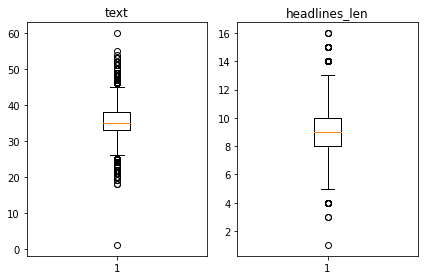

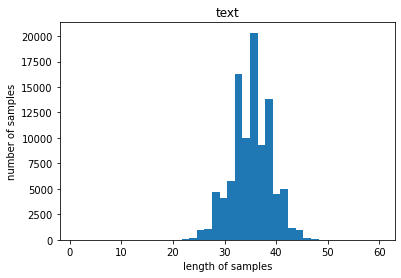

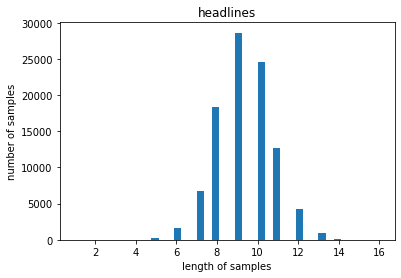

In [115]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1, 2, 2)
plt.boxplot(headlines_len)
plt.title('headlines_len')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [116]:
# text_max_len = 35
# headlines_max_len = 9

text_max_len = 50
headlines_max_len = 8

# text_max_len = 40
# summary_max_len = 10

# text_max_len = 40
# summary_max_len = 12

# text_max_len = 45
# headlines_max_len = 12

# text_max_len = 45
# headlines_max_len = 13

In [117]:
# 위의 길이가 적절한지 통계로 확인해보기
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [118]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [119]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수: ', len(data))

전체 샘플 수:  27105


### 시작 토큰, 종료 토큰 추가하기
- seq2seq에선 디코더의 입력과 출력 sostoekn, eostoken을 추가할 필요가 있다.
- **디코더의 입력**이며 `sostoken`이 맨 앞에 있는 문장은 `decoder_input`, **디코더의 출력**에 해당하며 `eostoken`이 맨 뒤에 붙은 문장은 `decoder_target`이라 명명하자.

In [120]:
# 요약 데이터에 시작 토큰과 종료 토큰을 추가함
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [121]:
encoder_input = np.array(data['text']) # 인코더의 입력 (text)
decoder_input = np.array(data['decoder_input']) # 디코더의 입력 (sostoken + Summary)
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블 (Summary + eostoken)

In [122]:
encoder_input_ = np.array(data['text']) # 컬럼 하나를 선택해 Series를 ndarray로 표현
encoder_input_ # 섞기 전

array(['union minister dharmendra pradhan wednesday claimed illegal mining mafia odisha operates control cm naveen patnaik state congress chief niranjan patnaik added time come people odisha put full stop activities time come us ask explanation corrupt government',
       'indian space research organisation wednesday unveiled human space flight centre bengaluru crore manned space mission gaganyaan scheduled isro said centre responsible development engineering systems crew survival space crew selection training also pursue activities sustained human space flight missions isro added',
       'least people killed others injured saudi arabia week due flooding heavy rain emergency services rescued people flooded areas half tabuk heavy rains hit mainly western northwestern parts saudi arabia near border jordan',
       ...,
       'pakistan started building nearly kilometer fence along border afghanistan according reports comes afghan militants reportedly killed six pakistani soldiers statio

In [123]:
# `encoder_input`과 크기, 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print(indices)

[21648 18207 23996 ... 17447  5928  3277]


In [124]:
# 이 정수 시퀀스(indices)를 통해 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 될 것이다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoer_target = decoder_target[indices]

In [125]:
encoder_input # 섞은 후

array(['nato released statement claiming recent petya wannacry ransomware attacks done state actor meaning could potentially viewed acts war nato added consider responding countermeasures countermeasure state response would typically illegal authorised following internationally wrongful acts another state',
       'bengaluru civic body friday removed unauthorised optical fibre cables measuring around km richmond cunningham roads cables belonging firms including vodafone airtel removed pedestrian died tripping low hanging cable authorities said earlier asked firms shift cables ground took action',
       'united airlines said scorpion reportedly emerged customer clothing flight evacuated thursday scorpion spotted onboard passengers reportedly faced three hour delay accommodated another flight initial reports suggested scorpion stung passenger united said paramedics determined stung',
       ...,
       'apple updated app store guidelines ban misleading apps market including content serv

In [126]:
# 8:2로 train/test 데이터 분리
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수: ', n_of_val)

테스트 데이터의 수:  5421


In [127]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


### 정수 인코딩
#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [128]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [129]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수 카운트
total_freq = 0 # 훈련 빈도수의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 낮은 단어의 등장 빈도수 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value # 총 빈도수
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value # rare 빈도수
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42437
등장 빈도가 6번 이하인 희귀 단어의 수: 30668
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11769
단어 집합에서 희귀 단어의 비율: 72.26712538586611
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.247203011514149


In [130]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [131]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3635, 103, 360, 407, 408, 3982, 2788, 462, 990, 18, 84, 3802, 76, 4903, 6716, 2746, 335, 3635, 6, 2747, 1761, 18, 718, 32, 575, 4067, 93, 2746, 184, 18], [179, 2320, 275, 42, 682, 3346, 6717, 5073, 7770, 3879, 39, 622, 1544, 7770, 1929, 1221, 45, 2701, 1744, 682, 261, 789, 2820, 2748, 224, 1, 33, 163, 1221, 4276, 7770, 991, 90, 332], [282, 771, 1, 22, 1762, 1745, 3275, 271, 2386, 54, 1763, 2821, 333, 22, 1233, 29, 724, 2510, 184, 271, 1436, 28, 790, 751, 282, 1, 4904]]


In [132]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [133]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18921
등장 빈도가 5번 이하인 희귀 단어의 수: 14278
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4643
단어 집합에서 희귀 단어의 비율: 75.46112784736536
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.129525117486748


In [134]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
input  [[1, 1905, 6, 307], [1, 366, 905, 3, 71], [1, 9, 813, 11, 185, 1480], [1, 1261, 502, 138, 175, 346], [1, 687, 712, 1302, 1691]]
target
decoder  [[572, 63, 1868, 267, 37, 2], [978, 203, 71, 164, 5, 222, 790, 2], [29, 97, 3, 141, 554, 467, 2], [9, 236, 312, 929, 659, 81, 2], [763, 115, 4, 8, 2]]


In [135]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]


# encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
# decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
# decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

# encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
# decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
# decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 8
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 21676
훈련 레이블의 개수 : 21676
테스트 데이터의 개수 : 5418
테스트 레이블의 개수 : 5418


In [136]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [137]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [138]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # 체크

In [139]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 50, 128)      1024000     ['input_9[0][0]']                
                                                                                                  
 lstm_11 (LSTM)                 [(None, 50, 256),    394240      ['embedding_5[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [140]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
85/85 [==============================] - 70s 724ms/step - loss: 5.0896 - val_loss: 4.8130
Epoch 2/50
85/85 [==============================] - 61s 713ms/step - loss: 4.9002 - val_loss: 4.7597
Epoch 3/50
85/85 [==============================] - 61s 715ms/step - loss: 4.8646 - val_loss: 4.7604
Epoch 4/50
85/85 [==============================] - 60s 707ms/step - loss: 4.8422 - val_loss: 4.7616
Epoch 4: early stopping


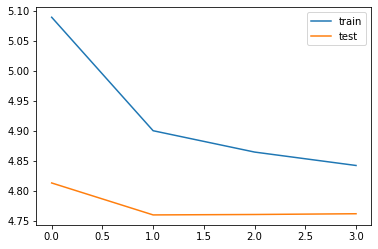

In [141]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [142]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [143]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [144]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [145]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' ' + sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [146]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [147]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : china probe exploring moon far side measure lunar night temperature scientists said probe measure temperature differences lunar day night help scientists estimate properties lunar soil probe project official said scientists reportedly estimate lunar night temperature could fall degrees 
실제 요약 : chinese probe to 


ValueError: in user code:

    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_6" (type Functional).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 256, but received input with shape (None, 1, 512)
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 50, 256), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)')
      • training=False
      • mask=None


## Step 3. 어텐션 매커니즘 사용하기 (추상적 요약)
- 일반적인 seq2seq보다 어텐션 메커니즘을 이용해 더 나은 성능을 내보자.

In [148]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [164]:
# 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [165]:
# from tensorflow.keras.layers import AdditiveAttention

# # 어텐션 층(어텐션 함수)
# attn_layer = AdditiveAttention(name='attention_layer')
# # 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
# attn_out= attn_layer([decoder_outputs, encoder_outputs])

# # 어텐션의 결과와 디코더의 hidden state들을 연결
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# # 디코더의 출력층
# decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# # 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()



# from attention_keras.layers.attention import AttentionLayer
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

TypeError: Exception encountered when calling layer "tf.keras.backend.rnn" (type TFOpLambda).

You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='tf.compat.v1.nn.softmax_1/Softmax:0', description="created by layer 'tf.compat.v1.nn.softmax_1'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

Call arguments received:
  • step_function=<function AttentionLayer.call.<locals>.energy_step at 0x7effb02baaf0>
  • inputs=tf.Tensor(shape=(None, None, 256), dtype=float32)
  • initial_states=['tf.Tensor(shape=(None, 50), dtype=float32)']
  • go_backwards=False
  • mask=None
  • constants=None
  • unroll=False
  • input_length=None
  • time_major=False
  • zero_output_for_mask=False

In [151]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
85/85 [==============================] - 70s 728ms/step - loss: 5.0511 - val_loss: 4.8243
Epoch 2/50
85/85 [==============================] - 61s 716ms/step - loss: 4.8568 - val_loss: 4.7860
Epoch 3/50
85/85 [==============================] - 60s 708ms/step - loss: 4.8272 - val_loss: 4.7718
Epoch 4/50
85/85 [==============================] - 61s 716ms/step - loss: 4.8057 - val_loss: 4.8148
Epoch 5/50
85/85 [==============================] - 61s 713ms/step - loss: 4.7872 - val_loss: 4.7911
Epoch 5: early stopping


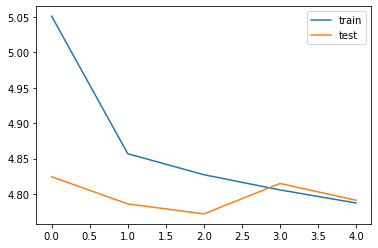

In [152]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [153]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [154]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [155]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [156]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' ' + sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
test 단계에선 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.
- text의 정수 시퀀스에선 패딩을 위해 사용된 숫자 0을 제외하고
- summary의 정수 시퀀스에선 숫자 0, sostoken, eostoken을 출력에서 제외하자.

In [157]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [158]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : china probe exploring moon far side measure lunar night temperature scientists said probe measure temperature differences lunar day night help scientists estimate properties lunar soil probe project official said scientists reportedly estimate lunar night temperature could fall degrees 
실제 요약 : chinese probe to 
예측 요약 :  india to to in


원문 : scientist wife lost crore one biggest online bengaluru according police scientist paid huge money claim crore online lottery prize death wife continued payments informed could claim lottery money instead 
실제 요약 : bengaluru couple lose cr in online lottery scam 
예측 요약 :  india to to in


원문 : total number related deaths india dropped report joint united nations programme hiv stated added half people living hiv around world access treatment first time history 
실제 요약 : deaths in india from to 
예측 요약 :  india to to in


원문 : saudi arabia prosecutors said online public order religious values public anyone producing material could face five years p

전치사만 나오는 불상사 ..!

***

# 5.

In [159]:
import requests
from summa.summarizer import summarize

In [160]:
text = '"Under no circumstance will we compromise the health \
and wellbeing of those Tongans who have already had a concerted \
effort against the virus by protecting themselves, and the virus \
is not present on the island," Australian Defense Minister Dutton \
said Tuesday.'

In [161]:
print('Summary:')
print(summarize(text, ratio=0.05))

Summary:



뉴스 기사: https://edition.cnn.com/travel/article/new-zealand-travel-covid-19/index.html

In [162]:
text2 = "New Zealand' landscape is the stuff of legend. \
Arthur's Pass National Park, with its soaring peaks and deep valleys \
is ripe for 'tramping,' the locals' term for a good, long hike.\
Cape Reinga and Ninety Mile Beach offer vast sea views from the tip \
of North Island. Meanwhile, indigenous Maori culture permeates \
every aspect of the country. Pick up an RV and it's easy to find \
an empty corner of this magical country to explore."

In [163]:
print('Summary:')
print(summarize(text2, ratio=0.5))
print('\n')

print('Summary:')
print(summarize(text2, ratio=0.8))
print('\n')

print('Summary:')
print(summarize(text2, words=20))

Summary:
Meanwhile, indigenous Maori culture permeates every aspect of the country.
Pick up an RV and it's easy to find an empty corner of this magical country to explore.


Summary:
New Zealand' landscape is the stuff of legend.
Meanwhile, indigenous Maori culture permeates every aspect of the country.
Pick up an RV and it's easy to find an empty corner of this magical country to explore.


Summary:
Meanwhile, indigenous Maori culture permeates every aspect of the country.
Pick up an RV and it's easy to find an empty corner of this magical country to explore.


앞으로 전처리 파일을 따로 저장해서 해야겠다.